In [2]:
pip install tensorflow pandas numpy scikit-learn seaborn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:



#load the FER-2013 dataset
data_path = 'model/data'
train_dir =  'data/train'
test_dir = 'data/test'

# Set the seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Image data generators
img_shape = 48
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.2
)

train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
    seed=seed
)

test_data = test_datagen.flow_from_directory(
    directory=test_dir,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
    subset="validation",
    seed=seed
)

# ResNet-50 Model creation function
def Create_ResNet50_Model(input_shape=(48, 48, 3)):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(7, activation='softmax'))
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create and compile the model
ResNet50_Model = Create_ResNet50_Model()

# Create the Adam optimizer with a custom learning rate
custom_optimizer = Adam(learning_rate=0.0001)
ResNet50_Model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Create Callbacks
checkpoint_path = "ResNet50_Model_Checkpoint.keras"
Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)
Early_Stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1)
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

# Train the model
ResNet50_history = ResNet50_Model.fit(
    train_data,
    validation_data=test_data,
    epochs=100,
    batch_size=batch_size,
    callbacks=callbacks,
)

# Evaluate the model on the test data
ResNet50_Score = ResNet50_Model.evaluate(test_data)
print("    Test Loss: {:.5f}".format(ResNet50_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50_Score[1] * 100))

# Evaluate the model on the train data
ResNet50_Score = ResNet50_Model.evaluate(train_data)
print("    Train Loss: {:.5f}".format(ResNet50_Score[0]))
print("Train Accuracy: {:.2f}%".format(ResNet50_Score[1] * 100))




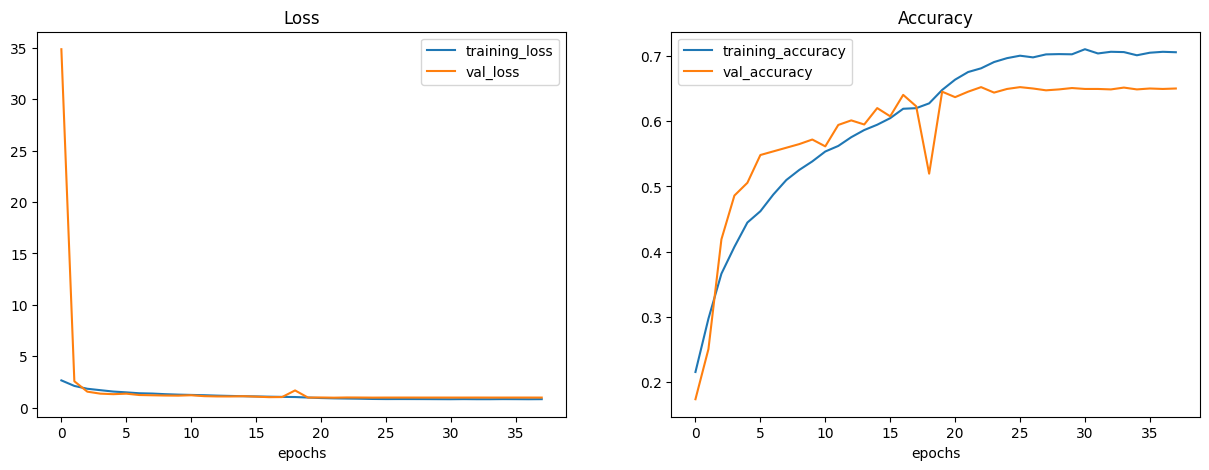

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step


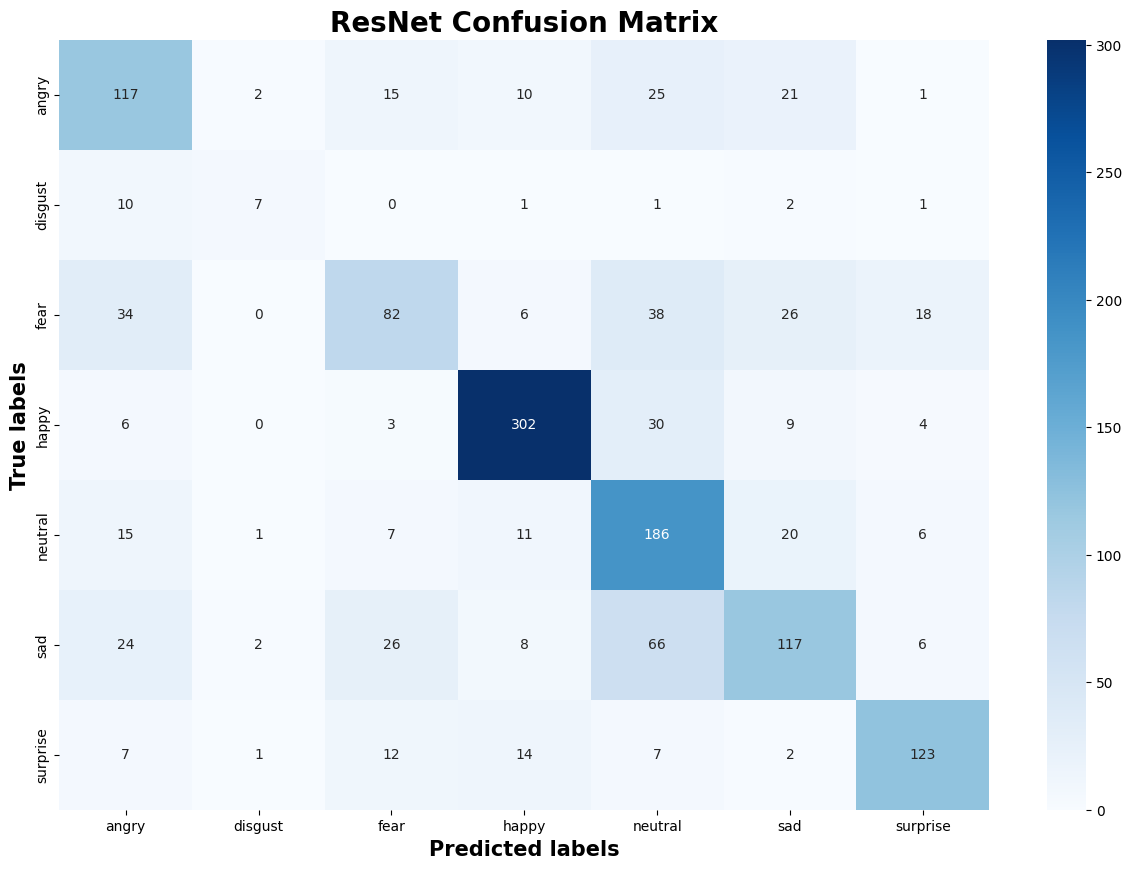

Classification report:
              precision    recall  f1-score   support

       angry       0.55      0.61      0.58       191
     disgust       0.54      0.32      0.40        22
        fear       0.57      0.40      0.47       204
       happy       0.86      0.85      0.86       354
     neutral       0.53      0.76      0.62       246
         sad       0.59      0.47      0.52       249
    surprise       0.77      0.74      0.76       166

    accuracy                           0.65      1432
   macro avg       0.63      0.59      0.60      1432
weighted avg       0.66      0.65      0.65      1432



In [15]:
# Plotting function
def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()

# Plot the training curves
plot_curves(ResNet50_history)

# Generate predictions
resnet50_Predictions = ResNet50_Model.predict(test_data)

# Choosing the highest probability class in every prediction
resnet50_Predictions = np.argmax(resnet50_Predictions, axis=1)

# Plot confusion matrix
fig, ax= plt.subplots(figsize=(15,10))
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

cm = confusion_matrix(true_classes, resnet50_Predictions)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=ax)

ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet Confusion Matrix', fontsize=20, fontweight='bold')
plt.show()

# Print classification report
print('Classification report:')
print(classification_report(true_classes, resnet50_Predictions, target_names=class_labels))

In [8]:
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Constants and Paths
DATA_DIRECTORY = 'model/data'
TRAINING_DIRECTORY = 'data/train'
TESTING_DIRECTORY = 'data/test'
IMAGE_SIZE = 48
BATCH_SIZE = 64
RANDOM_SEED = 42

# Set the seed for reproducibility
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Data Augmentation and Preprocessing
training_data_gen = ImageDataGenerator(
    rescale=1. / 255,           # Normalize pixel values
    rotation_range=10,          # Randomly rotate images
    zoom_range=0.2,             # Randomly zoom into images
    width_shift_range=0.1,      # Randomly shift images horizontally
    height_shift_range=0.1,     # Randomly shift images vertically
    horizontal_flip=True,       # Randomly flip images horizontally
    validation_split=0.2        # Use 20% of data for validation
)

validation_data_gen = ImageDataGenerator(
    rescale=1. / 255,           # Normalize pixel values
    validation_split=0.2        # Use 20% of data for validation
)

# Load Training Data
train_data = training_data_gen.flow_from_directory(
    directory=TRAINING_DIRECTORY,
    class_mode="categorical",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    shuffle=True,
    batch_size=BATCH_SIZE,
    subset='training',
    seed=RANDOM_SEED
)

# Load Validation Data
validation_data = validation_data_gen.flow_from_directory(
    directory=TESTING_DIRECTORY,
    class_mode="categorical",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE,
    subset="validation",
    seed=RANDOM_SEED
)

# Function to Create Model
def build_custom_resnet(input_shape=(48, 48, 3)):
    base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    model = Sequential()
    model.add(base_resnet)
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(7, activation='softmax'))
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create and compile the model
emotion_model = build_custom_resnet()

# Callbacks for Model Training
checkpoint_cb = ModelCheckpoint("best_emotion_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1)
early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
final_model_saver_cb = ModelCheckpoint("final_emotion_model.keras", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# List of Callbacks
callbacks_list = [checkpoint_cb, early_stopping_cb, reduce_lr_cb, final_model_saver_cb]

# Model Training
training_history = emotion_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=100,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_list,
)

# Evaluate the model on the validation data
validation_scores = emotion_model.evaluate(validation_data)
print("Validation Loss: {:.5f}".format(validation_scores[0]))
print("Validation Accuracy: {:.2f}%".format(validation_scores[1] * 100))

# Evaluate the model on the training data
training_scores = emotion_model.evaluate(train_data)
print("Training Loss: {:.5f}".format(training_scores[0]))
print("Training Accuracy: {:.2f}%".format(training_scores[1] * 100))

# Save the final model
emotion_model.save("final_emotion_model.h5")



Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.
Epoch 1/100


C:\Users\Luca Marini\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1837 - loss: 2.8869
Epoch 1: val_accuracy improved from -inf to 0.17388, saving model to best_emotion_model.keras

Epoch 1: val_accuracy improved from -inf to 0.17388, saving model to final_emotion_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 460s 1s/step - accuracy: 0.1838 - loss: 2.8862 - val_accuracy: 0.1739 - val_loss: 34.8826 - learning_rate: 1.0000e-04
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - accuracy: 0.2828 - loss: 2.1849
Epoch 2: val_accuracy improved from 0.17388 to 0.25070, saving model to best_emotion_model.keras

Epoch 2: val_accuracy improved from 0.17388 to 0.25070, saving model to final_emotion_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.2829 - loss: 2.1847 - val_accuracy: 0.2507 - val_loss: 2.5529 - learning_rate: 1.0000e-04
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - accuracy: 0.3532 - loss: 1.8684
Epoch 3: val_accuracy improved from 0.25070 to 0.41899, saving model 

Training Loss: 0.78999
Training Accuracy: 71.32%


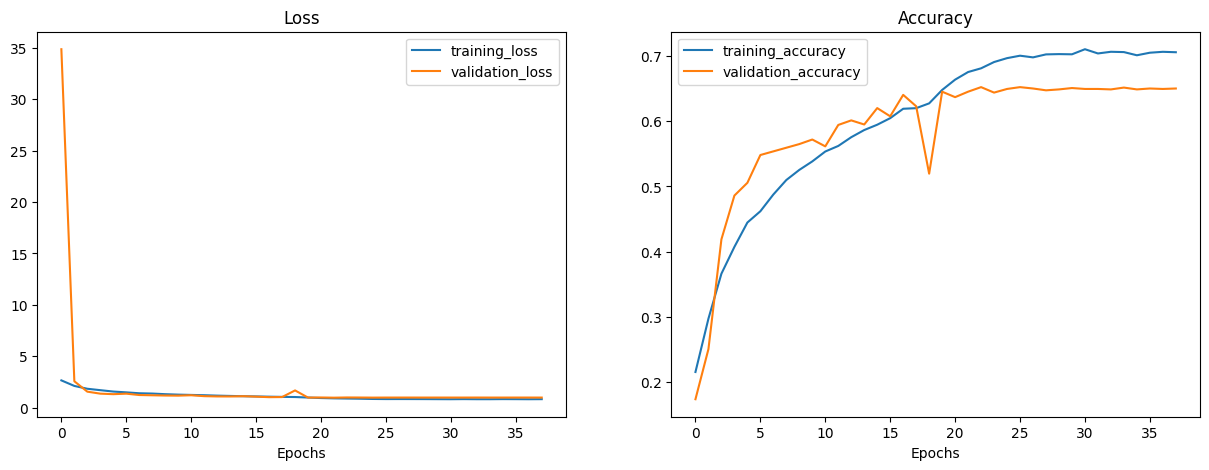

23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step


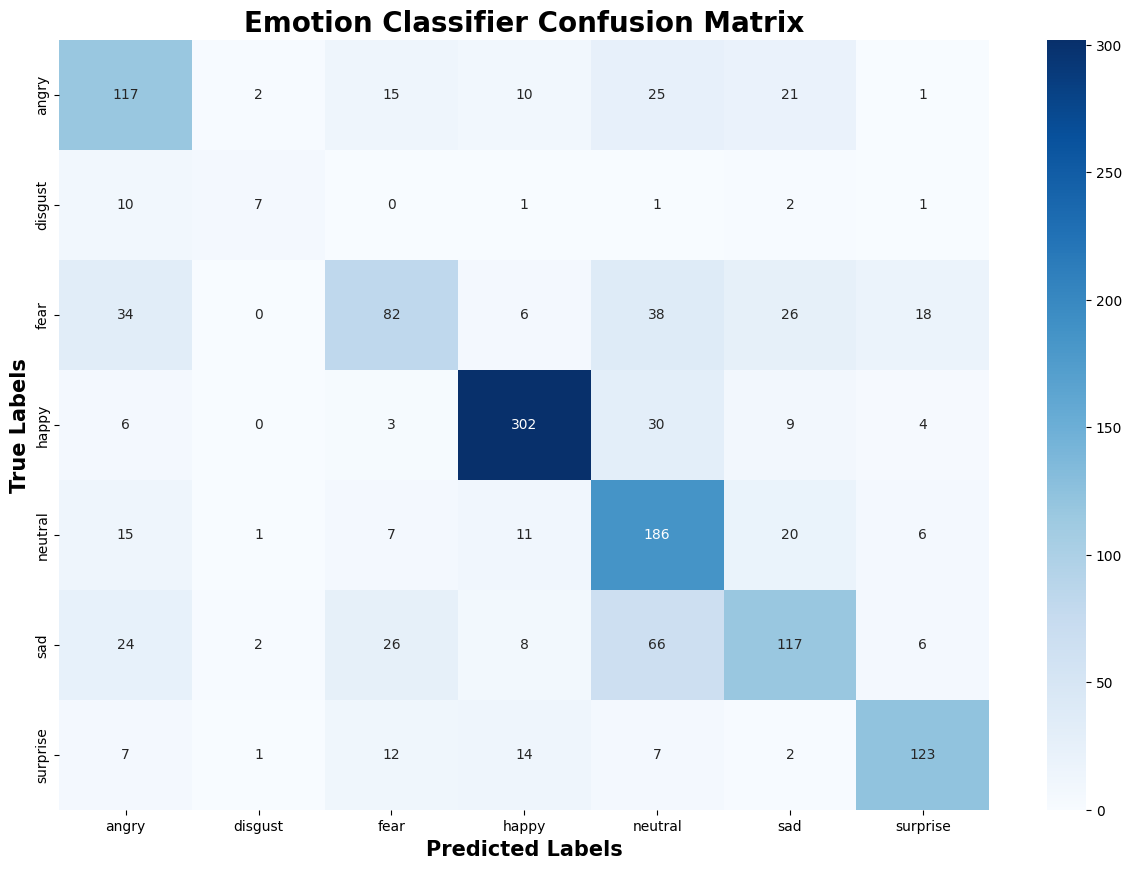

Classification Report:
              precision    recall  f1-score   support

       angry       0.55      0.61      0.58       191
     disgust       0.54      0.32      0.40        22
        fear       0.57      0.40      0.47       204
       happy       0.86      0.85      0.86       354
     neutral       0.53      0.76      0.62       246
         sad       0.59      0.47      0.52       249
    surprise       0.77      0.74      0.76       166

    accuracy                           0.65      1432
   macro avg       0.63      0.59      0.60      1432
weighted avg       0.66      0.65      0.65      1432



In [9]:
def plot_training_curves(history):
    """
    Plots the training and validation loss and accuracy curves.
    
    Parameters:
    history: History object returned by the fit method of the model.
    """
    train_loss = history.history["loss"]  # Training loss
    validation_loss = history.history["val_loss"]  # Validation loss
    train_accuracy = history.history["accuracy"]  # Training accuracy
    validation_accuracy = history.history["val_accuracy"]  # Validation accuracy
    epochs = range(len(history.history["loss"]))  # Number of epochs

    plt.figure(figsize=(15, 5))  # Set the figure size

    # Plot loss
    plt.subplot(1, 2, 1)  # Create subplot for loss
    plt.plot(epochs, train_loss, label="training_loss")  # Plot training loss
    plt.plot(epochs, validation_loss, label="validation_loss")  # Plot validation loss
    plt.title("Loss")  # Title of the plot
    plt.xlabel("Epochs")  # X-axis label
    plt.legend()  # Add legend

    # Plot accuracy
    plt.subplot(1, 2, 2)  # Create subplot for accuracy
    plt.plot(epochs, train_accuracy, label="training_accuracy")  # Plot training accuracy
    plt.plot(epochs, validation_accuracy, label="validation_accuracy")  # Plot validation accuracy
    plt.title("Accuracy")  # Title of the plot
    plt.xlabel("Epochs")  # X-axis label
    plt.legend()  # Add legend

    plt.show()  # Display the plots

# Usage example with emotion model training history
plot_training_curves(training_history)  # Plot training and validation curves

# Predicting and plotting the confusion matrix for the emotion model
predicted_classes = emotion_model.predict(validation_data)  # Predict the classes of the validation data

# Choosing highest probability class in every prediction
predicted_classes = np.argmax(predicted_classes, axis=1)  # Get the index of the highest probability class

fig, ax = plt.subplots(figsize=(15, 10))  # Set the figure size
true_classes = validation_data.classes  # True labels from the validation data generator
class_labels = list(validation_data.class_indices.keys())  # Class names from the validation data generator

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)  # Compute confusion matrix

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=ax)  # Plot heatmap

ax.set_xlabel('Predicted Labels', fontsize=15, fontweight='bold')  # Set x-axis label
ax.set_ylabel('True Labels', fontsize=15, fontweight='bold')  # Set y-axis label
ax.set_title('Emotion Classifier Confusion Matrix', fontsize=20, fontweight='bold')  # Set plot title

plt.show()  # Display the plot

# Print classification report
print('Classification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_labels))